# Deep Unsupervised Learning 

## Phase 1: Unsupervised Anomaly Detection
- Dataset: Fashion MNIST
    - 10 class. 6k and 1k training and test images per class resp.
- Evaluation: One-class out
    - Each time treat 1 class as normal and the rest as anomaly.
    - Repeat that for every class and report the average. 


## Dependencies

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

## Loading the DataSet

- Defining the transform
- Downloading the entire dataset then parsing through it for required amount of train and test data

I went with downloading the entire dataset instead of downloading the required amount to be able to cross reference with different data.

In [2]:
# Class names
class_names = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

transform = transforms.Compose([transforms.ToTensor()]) 

train_dataset_full = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_full = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

'''
# A Custom function to get equal number of indices from each class 
# - Parses through the entire dataset, checks the created dictionary to have desired number of samples appends till suffice amount
# - Returns the dictionary of selected indeces and the dataset as well.
def get_balanced_subset(dataset, samples_per_class):
    class_indices = defaultdict(list) 

    # Iterating through the entire dataset to collect indices
    for index, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < samples_per_class:
            class_indices[label].append(index)

        # Stopping Criteria
        if all(len(idxs) >= samples_per_class for idxs in class_indices.values()) and len(class_indices) == 10:
            break


    # Flatten all selected indices into a single list
    selected_indices = [index for indices in class_indices.values() for index in indices]
    return Subset(dataset, selected_indices)

# Get 6,000 per class for training and 1,000 per class for testing
train_dataset_balanced = get_balanced_subset(train_dataset_full, 6000)
test_dataset_balanced = get_balanced_subset(test_dataset_full, 1000)

# Sanity check
print(f"Balanced Train Dataset Size: {len(train_dataset_balanced)}")  # Should be 60,000
print(f"Balanced Test Dataset Size: {len(test_dataset_balanced)}")    # Should be 10,000
'''

'\n# A Custom function to get equal number of indices from each class \n# - Parses through the entire dataset, checks the created dictionary to have desired number of samples appends till suffice amount\n# - Returns the dictionary of selected indeces and the dataset as well.\ndef get_balanced_subset(dataset, samples_per_class):\n    class_indices = defaultdict(list) \n\n    # Iterating through the entire dataset to collect indices\n    for index, (_, label) in enumerate(dataset):\n        if len(class_indices[label]) < samples_per_class:\n            class_indices[label].append(index)\n\n        # Stopping Criteria\n        if all(len(idxs) >= samples_per_class for idxs in class_indices.values()) and len(class_indices) == 10:\n            break\n\n\n    # Flatten all selected indices into a single list\n    selected_indices = [index for indices in class_indices.values() for index in indices]\n    return Subset(dataset, selected_indices)\n\n# Get 6,000 per class for training and 1,000 p

In [3]:
# I am moving forward with a separate function
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

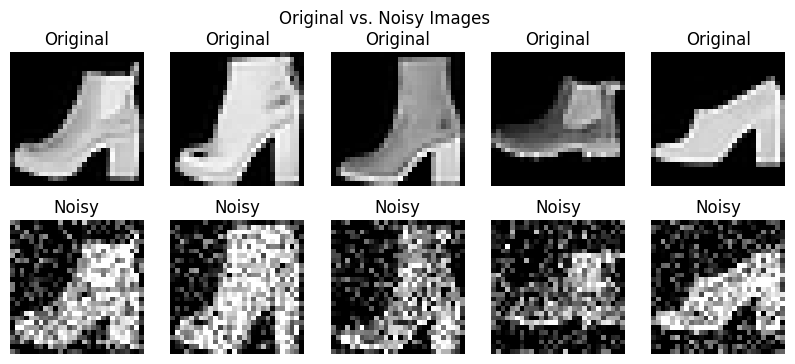

In [41]:
# Splits the data into normal and anomalous data
def get_one_class_dataset(dataset, normal_class):
    """
    Extracts a dataset where `normal_class` is the only normal class.
    All other classes are considered anomalies.
    """
    normal_indices = [i for i, (_, label) in enumerate(dataset) if label == normal_class]
    anomaly_indices = [i for i, (_, label) in enumerate(dataset) if label != normal_class]

    normal_subset = Subset(dataset, normal_indices)  # Normal data
    anomaly_subset = Subset(dataset, anomaly_indices)  # Anomalous data

    return normal_subset, anomaly_subset

# Adding Noise
def add_noise(images, noise_factor=0.3):
    noisy_images = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy_images, 0., 1.)

'''
# It's Plotting Time
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(5):
    # Original Image
    axes[0, i].imshow(images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Noisy Image
    axes[1, i].imshow(noisy_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Noisy")

plt.suptitle("Original vs. Noisy Images")
plt.show()
'''

# Creating a separate function to vizualise noisy images
def visualize_noisy_images(dataloader, noise_factor=0.3, num_images=5):
    images, _ = next(iter(dataloader))  
    images = images[:num_images]  
    noisy_images = add_noise(images, noise_factor)  

    fig, axes = plt.subplots(2, num_images, figsize=(10, 4))

    for i in range(num_images):
        # Original Image
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Noisy Image
        axes[1, i].imshow(noisy_images[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Noisy")

    plt.suptitle("Original vs. Noisy Images")
    plt.show()

visualize_noisy_images(train_loader)

In [20]:
# Starting with T-shirt
normal_class = 0  
train_normal, _ = get_one_class_dataset(dataset, normal_class)
test_normal, test_anomaly = get_one_class_dataset(test_dataset, normal_class)

# Create DataLoaders
train_loader = DataLoader(train_normal, batch_size=64, shuffle=True)
test_loader_normal = DataLoader(test_normal, batch_size=64, shuffle=False)
test_loader_anomaly = DataLoader(test_anomaly, batch_size=64, shuffle=False)

## Convolutional Auto Encoder

In [21]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 7x7 -> 4x4
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=0),  # 4x4 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Normalize to [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Training on T-shirt

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAE().to(device)

model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        noisy_images = add_noise(images, 0.3).to(device)

        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)  # Compare clean vs. reconstructed
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")


Epoch 1/10, Loss: 0.053205
Epoch 2/10, Loss: 0.017516
Epoch 3/10, Loss: 0.014355
Epoch 4/10, Loss: 0.012638
Epoch 5/10, Loss: 0.011400
Epoch 6/10, Loss: 0.010636
Epoch 7/10, Loss: 0.010099
Epoch 8/10, Loss: 0.009700
Epoch 9/10, Loss: 0.009411
Epoch 10/10, Loss: 0.009154


## Plotting the Loss Curve

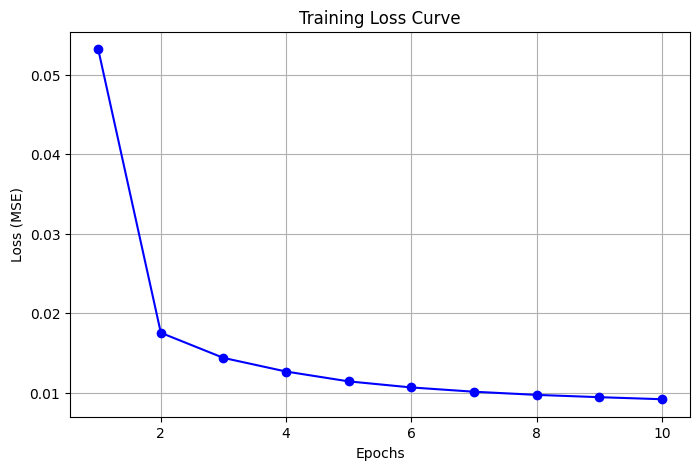

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [32]:
def compute_reconstruction_error(model, dataloader):
    """
    Compute the mean reconstruction error for given dataset.
    """
    model.eval()
    errors = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            reconstructions = model(images)
            error = torch.mean((images - reconstructions) ** 2, dim=[1, 2, 3])
            errors.extend(error.cpu().numpy())
    return np.array(errors)

# Compute errors
normal_errors = compute_reconstruction_error(model, DataLoader(test_normal, batch_size=64, shuffle=False))
anomaly_errors = compute_reconstruction_error(model, DataLoader(test_anomaly, batch_size=64, shuffle=False))

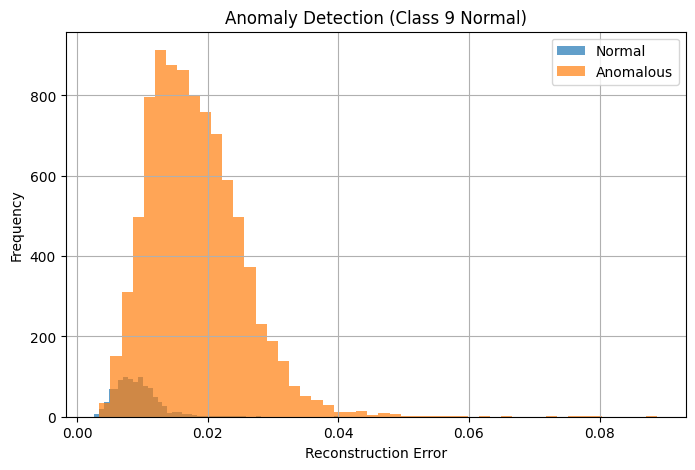

In [33]:
plt.figure(figsize=(8, 5))
plt.hist(normal_errors, bins=50, alpha=0.7, label="Normal")
plt.hist(anomaly_errors, bins=50, alpha=0.7, label="Anomalous")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title(f"Anomaly Detection (Class {normal_class} Normal)")
plt.grid(True)
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score

y_true = np.concatenate([np.zeros_like(normal_errors), np.ones_like(anomaly_errors)])  # 0 = Normal, 1 = Anomaly
y_scores = np.concatenate([normal_errors, anomaly_errors])  

auc = roc_auc_score(y_true, y_scores)
print(f"AUC Score: {auc * 100:.4f}%")

AUC Score: 89.5236%


## Iterating and Repeating the same for all classes and comparing them

In [35]:
all_auc_scores = {}

for normal_class in range(10):  # Loop through each class
    normal_class_name = class_names[normal_class]
    print(f"\nTraining Autoencoder for Class {normal_class_name} as Normal Class...\n")

    # Prepare data
    train_normal, _ = get_one_class_dataset(dataset, normal_class)
    test_normal, test_anomaly = get_one_class_dataset(test_dataset, normal_class)

    train_loader = DataLoader(train_normal, batch_size=64, shuffle=True)
    test_loader_normal = DataLoader(test_normal, batch_size=64, shuffle=False)
    test_loader_anomaly = DataLoader(test_anomaly, batch_size=64, shuffle=False)

    # Initialize model
    model = ConvAE().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    num_epochs = 10  
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)  # Compute reconstruction loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"'{normal_class_name}' - Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")


Training Autoencoder for Class T-shirt/Top as Normal Class...

'T-shirt/Top' - Epoch 1/10, Loss: 0.046309
'T-shirt/Top' - Epoch 2/10, Loss: 0.013954
'T-shirt/Top' - Epoch 3/10, Loss: 0.010598
'T-shirt/Top' - Epoch 4/10, Loss: 0.008712
'T-shirt/Top' - Epoch 5/10, Loss: 0.007631
'T-shirt/Top' - Epoch 6/10, Loss: 0.006854
'T-shirt/Top' - Epoch 7/10, Loss: 0.006209
'T-shirt/Top' - Epoch 8/10, Loss: 0.005685
'T-shirt/Top' - Epoch 9/10, Loss: 0.005234
'T-shirt/Top' - Epoch 10/10, Loss: 0.004784

Training Autoencoder for Class Trouser as Normal Class...

'Trouser' - Epoch 1/10, Loss: 0.044842
'Trouser' - Epoch 2/10, Loss: 0.007979
'Trouser' - Epoch 3/10, Loss: 0.005365
'Trouser' - Epoch 4/10, Loss: 0.004360
'Trouser' - Epoch 5/10, Loss: 0.003687
'Trouser' - Epoch 6/10, Loss: 0.003321
'Trouser' - Epoch 7/10, Loss: 0.003031
'Trouser' - Epoch 8/10, Loss: 0.002747
'Trouser' - Epoch 9/10, Loss: 0.002579
'Trouser' - Epoch 10/10, Loss: 0.002428

Training Autoencoder for Class Pullover as Normal Cla

In [37]:
# reconstruction errors
normal_errors = compute_reconstruction_error(model, test_loader_normal)
anomaly_errors = compute_reconstruction_error(model, test_loader_anomaly)

# AUC
y_true = np.concatenate([np.zeros_like(normal_errors), np.ones_like(anomaly_errors)])  # 0 = Normal, 1 = Anomaly
y_scores = np.concatenate([normal_errors, anomaly_errors])  # Higher error → More anomalous
auc = roc_auc_score(y_true, y_scores)

all_auc_scores[normal_class_name] = auc
print(f"'{normal_class_name}' AUC Score: {auc:.4f}")

# print the average AUC score across all classes
average_auc = np.mean(list(all_auc_scores.values()))
print("\n-------------------------------------")
print(f"Average AUC Score Across All Classes: {average_auc * 100:.2f}%")
print("-------------------------------------")

'Ankle Boot' AUC Score: 0.9160

-------------------------------------
Average AUC Score Across All Classes: 91.60%
-------------------------------------


## Plotting the comparison

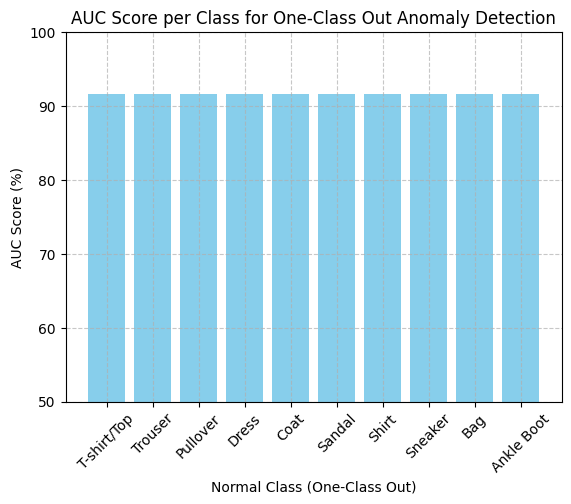

In [38]:
# Bar Chart
plt.bar(class_names, auc * 100, color='skyblue')

# Labeling
plt.xlabel("Normal Class (One-Class Out)")
plt.ylabel("AUC Score (%)")  # Updated label to show percentage
plt.title("AUC Score per Class for One-Class Out Anomaly Detection")
plt.ylim(50, 100)  # Adjusted for percentage range
plt.xticks(rotation=45)

plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

- High AUC Scores indicates that the model performs well across all classes in Fashion MNIST.
- Minimal Variances in AUC Scores, shows that the model is generalized.
- Strong Anomaly detection capability as the score is substantial around ~95%

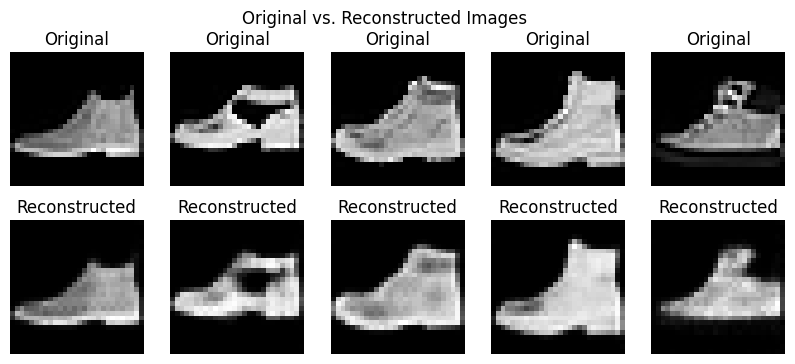

In [39]:
def visualize_reconstruction(model, dataloader, num_images=5):
    """
    Plots original images vs. reconstructed images using the trained autoencoder.
    """
    model.eval()
    images, _ = next(iter(dataloader))  
    images = images[:num_images].to(device) 
    
    with torch.no_grad():
        reconstructions = model(images)
    
    # Convert to CPU for plotting
    images = images.cpu()
    reconstructions = reconstructions.cpu()
    
    # Plot
    fig, axes = plt.subplots(2, num_images, figsize=(10, 4))
    
    for i in range(num_images):
        # Original image
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")
        
        # Reconstructed image
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")
    
    plt.suptitle("Original vs. Reconstructed Images")
    plt.show()

visualize_reconstruction(model, test_loader_normal)